In [ ]:
# default_exp features

In [ ]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Features


> This module contains all the necessary functions for extracting and organizing features from videos.

In [ ]:
#export
import cv2
import ffmpeg

import torch

import numpy as np

from abc import ABC, abstractmethod

from fastprogress.fastprogress import progress_bar

# tango
from tango.prep import *

from tango.cnn import *

from pathlib import Path

from matplotlib import pyplot as plt

from nbdev.showdoc import *

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
#export
class Extractor(ABC):
 
    def __init__(self, extractor):
        self.extractor = extractor
        super().__init__()
    
    @abstractmethod
    def extract(self, img):
        pass

In [ ]:
#export
class SIFTExtractor(Extractor):

    def extract(self, img):
        _, features = self.extractor.detectAndCompute(img, None)
        return features
    
class CNNExtractor(Extractor):
   
    def extract(self, img):
        return self.extractor.getFeatures(img)

In [ ]:
#hide
imgs = get_rand_imgs(video_paths[0], 30_000, n = 100)

In [ ]:
#hide
#learn, linear_output_layer = cnn.trainPetsModel()
#extractor = CNNExtractor(cnn.createExtractor(None, None, 'resnet50', False))
extractor = CNNExtractor(cnn.createLayeredExtractor())

In [ ]:
#hide
#CNN features
# features = extractor.extract(imgs[0]);
# print(features.shape)

# # SIFT features
# features = extractor.extract(imgs[1])
# print(features.shape)

#Layered implementation
features = extractor.extract(imgs[0])

In [ ]:
#hide
print(features.shape)

(1, 202752)


In [ ]:
#export
def gen_vcodebook(imgs, extractor, vwords = 10_000):
    """
        Constructs a visual codebook based on the given images.
        You can change vwords to increase the vocabulary of the codebook.
    """
    features_list = []
    for img in imgs:
        features = extractor.extract(img)
        features_list.extend(features)
    
    codebook = KMeans(n_clusters = vwords)
    codebook.fit(features_list)
    
    return codebook

In [ ]:
#hide
vwords = 20
codebook = gen_vcodebook(imgs, extractor, vwords)

[5]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
       5.4 , 5.45, 5.5 ]))


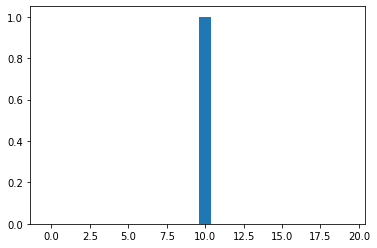

In [ ]:
#hide
labels = codebook.predict(features)
hist = np.histogram(labels, bins = vwords)
plt.bar(range(vwords), hist[0])

In [ ]:
#export
def get_df(imgs, extractor, codebook):
    """Generates the document frequency for the visual words"""
    hist = None
    for img in imgs:
        features = extractor.extract(img);
        vw = codebook.predict(features)
        if hist is not None:
            hist += np.clip(np.histogram(vw, bins = vwords)[0], 0, 1)
        else:
            hist = np.clip(np.histogram(vw, bins = vwords)[0], 0, 1)
    
    return hist

In [ ]:
#hide
df = get_df(imgs, extractor, codebook)

In [ ]:
#hide
df

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,   0,   0])

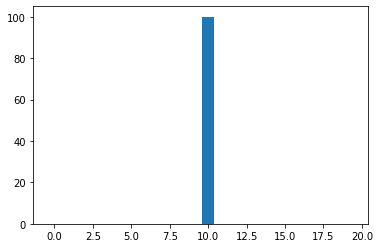

In [ ]:
#hide
plt.bar(range(vwords), df)
plt.show()

In [ ]:
#export
def get_bovw(vid_path, extractor, codebook):
    """Generates the bag of visual words (bovw) for an entire video."""
    vid = cv2.VideoCapture(str(vid_path))
    
    # checks whether frames were extracted 
    success = 1
    bovw = np.array([])
    for i in progress_bar(range(100)):
        # vid object calls read 
        # function extract frames 
        success, img = vid.read() 
        if success:
            features = extractor.extract(img)
            vw = codebook.predict(features)
            bovw = np.concatenate((bovw, vw))
    
    hist = np.histogram(bovw, bins = vwords)[0]
    return hist, bovw

In [ ]:
#hide
hist, bovw = get_bovw(video_paths[3], extractor, codebook)
hist

array([61,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 39])

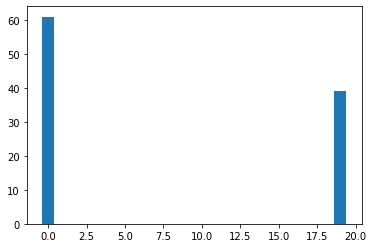

array([61,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 39])

In [ ]:
#hide
plt.bar(range(vwords), hist)
plt.show()
hist

In [ ]:
#export
def calc_tf_idf(tfs, dfs):
    tf_idf = np.array([])
    for tf, df in zip(tfs, dfs):
        tf = tf / np.sum(tfs)
        idf = np.log(len(tfs) / (df + 1))
        tf_idf = np.append(tf_idf, tf * idf)
    
    return tf_idf

In [ ]:
#hide
tf_idf_pix2 = calc_tf_idf(hist, df)
tf_idf_pix2

array([ 1.827397,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
       -0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  1.168336])

In [ ]:
#hide
hist2, bovw2 = get_bovw(video_paths[2], extractor, codebook)
tf_idf_pix1 = calc_tf_idf(hist2, df)

In [ ]:
#hide
hist3, bovw3 = get_bovw(video_paths[4], extractor, codebook)
tf_idf_car1 = calc_tf_idf(hist3, df)

In [ ]:
#hide
hist4, bow4 = get_bovw(video_paths[5], extractor, codebook)
tf_idf_car2 = calc_tf_idf(hist4, df)

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_pix2) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_pix2))

0.9983245500747429

In [ ]:
#hide
np.dot(tf_idf_car1, tf_idf_car2) / (np.linalg.norm(tf_idf_car1) * np.linalg.norm(tf_idf_car2))

0.876008965097361

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_car1) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_car1))

0.5946241924447379

In [ ]:
#hide
np.dot(tf_idf_pix2, tf_idf_car2) / (np.linalg.norm(tf_idf_pix2) * np.linalg.norm(tf_idf_car2))

0.8824757778567319

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_pix1) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_pix1))

0.9999999999999998

In [ ]:
#hide
np.dot(tf_idf_car1, tf_idf_car1) / (np.linalg.norm(tf_idf_car1) * np.linalg.norm(tf_idf_car1))

0.9999999999999998

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/art_and_design/pixel_art_paint/scenario2/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/art_and_design/pixel_art_paint/scenario1/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/auto_and_vehicles/car_part/scenario1/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_prep.ipynb.
Converted 01_features.ipynb.
Converted 02_eval.ipynb.
Converted 03_cnn.ipynb.
Converted android_cnn.ipynb.
Converted index.ipynb.
Converted lesson1-pets.ipynb.
Converted replicate_lesson1_pets.ipynb.
Converted test.ipynb.
Converted test2.ipynb.
